<font size=6>**ML Classification**</font>

In this session we focus on another important application for machine learning, the **Classification**. <br>
We will provide a simple problem (with multiple **intermediate tasks**):

- to demonstrate basic **visualization** of the data 
- to show the basic steps in an **application** of an algorith (*or two!*)
- to present the necessary performance **metrics**
- to investigate differences in **binary and multiclass** approaches

$\rightarrow$ The target is to have an practical application example of an algorith to <u>understand the approach</u> and (hopefully!) use it for your own research.

# Types of Classification


## Flavors

Classification can come in two major flavors, based on the type of intervention by the user:

- **Unsupervised**: The classification is defined "unsupervised" when the user does not provide labels during the training process and the machine learns the definition of each class from the data. This is exactly the case of "Clustering" that we saw in the previous session.  

>    _In practice, the machine learns to cluster objects with similar properties._


- **Supervised**: The classification is defined "supervised" when the user provides a label for each object in the training set. In this case, the idea is that we can train the model to associate the label with some given characteristics of the training data.

>    _In practice, the machine learns to find similarities between objects with the same label._

## Terminology

Keep in mind that:

- **class** or **label** are used interchangeably
- **samples** (i.e. the items) can be of any arbitrary type (e.g. a string, an image, or numbers) - however, in astronomy we mainly refer to **objects or sources**, since samples correspond to their collections <br>(so... samples in ml terminology and objects/sources in astronomy!) 
- the objects/samples are categorized based on their **properties** or **features** (the actual information that we pass to the machine, e.g. the pixel intensities in the case of an image).

# The sample for our classification example

To properly classify a star we need a spectrum. However, this is time consuming and limited to one (single slit spectroscopy) or a few tens of sources (multi-object spectroscopy). On the contrary, imaging in various different filters can be done easily and for thousands of sources per image. Photometry at different wavelengths result in a very low-resolution "spectrum".</br> 

<center><img src="images/Girardi2002-photometric systems.gif"> 
Figure 2.1. The filter+detector transmission curves for a number of different systems, along with indicative spectra of Vega, the Sun, and a M5 giant. <br>
(Fig 3. from <a href="https://ui.adsabs.harvard.edu/abs/2002A%26A...391..195G/abstract" target="_blank" rel="noopener noreferrer"> Girardi et al. (2002)</a>)</center>

In this example we are using a set of photometric measurements (from optical to mid-IR bands) for a sample of massive evolved stars in the Large Magellanic Cloud (based on these works: [Bonanos et al. (2009) AJ, 138, 1003](https://ui.adsabs.harvard.edu/abs/2009AJ....138.1003B/abstract), [Neugent et al. (2012), ApJ, 749, 177](https://ui.adsabs.harvard.edu/abs/2012ApJ...749..177N/abstract), and [Davies, Crowther & Beasor (2018), MNRAS, 478, 313](https://ui.adsabs.harvard.edu/abs/2018MNRAS.478.3138D/abstract)). 

<center><img src="images/Massey2013-HRD.png" width=600> 
Figure 2.2. A slightly modified version of Fig. 1 from <a href="https://ui.adsabs.harvard.edu/abs/2013NewAR..57...14M/abstract" target="_blank" rel="noopener noreferrer"> Massey et al. (2013)</a>)</center>

Our aim is to use a method that will help us **distinguish different classes** of objects. For our purposes we will use OBA stars (main-sequense objects), OBAe (a subcategory of OBA stars with circumstellar disks and emission lines), Wolf-Rayet stars (hot evolved stars with strong stellar winds that actually strip their envelopes), Yellow and Red supergiants (evolved massive stars). For convenience we will use OBA, OBAe, WR, YSG, and RSG, respectively, as labels.

&#9733; A similar, but more elaborated, implementation is performed in [Maravelias et al. (2022), A&A, 666, 122](https://ui.adsabs.harvard.edu/abs/2022A%26A...666A.122M/abstract).



## Load and examine data


In [1]:
import numpy as np
import matplotlib.pyplot as plt

&#9755; You do not need ```pandas``` to do everything with files! ```genfromtxt``` is very powerful but has its tweaks! 

In [2]:
dfile = "data/LMC_phot_data.csv"
miss_value = -999.0  # when entries are missing

data = np.genfromtxt(dfile, dtype=None, encoding='utf8', 
                     comments='#', delimiter=',', 
                     filling_values = miss_value, 
                     names=True, autostrip='Yes')

#examine data
print("Let us see what we have:\n")
print("The column names:")
print(data.dtype.names)
print("-"*25)
print("Let's print the spectral types only:")
print(data['SpT'])
print("-"*25)

Let us see what we have:

The column names:
('Name', 'RAJ2000', 'DEJ2000', 'U', 'e_U', 'B', 'e_B', 'V', 'e_V', 'I', 'e_I', 'J', 'e_J', 'H', 'e_H', 'K', 'e_K', '36', 'e_36', '45', 'e_45', '58', 'e_58', '80', 'e_80', '24', 'e_24', 'SpT')
-------------------------
Let's print the spectral types only:
['WR' 'OBAe' 'OBA' ... 'YSG' 'YSG' 'YSG']
-------------------------


_HINT_: We want to group the different spectral classes found, and for this we are using the indeces and not the data values directly. in that way we can select all data for the same objects.

In [3]:
from collections import defaultdict

classes = defaultdict(list)

for i in range(0,len(data['SpT'])): 
#    print(i, data['SpT'][i])
    classes[data['SpT'][i]].append(i)

#print(classes)
unique_cls = sorted(set(classes.keys()))
print(unique_cls)
print("> SUMMARY of loaded data:")
print("=========================")
for sptype in unique_cls:
    number = len(classes[sptype])
    print(f"{sptype:-<6s}--> {number:>3} stars")

['OBA', 'OBAe', 'RSG', 'WR', 'YSG']
> SUMMARY of loaded data:
OBA-----> 370 stars
OBAe---->  73 stars
RSG-----> 297 stars
WR------>  91 stars
YSG-----> 208 stars


In [4]:
bands = [b for b in data.dtype.names[3:-1] if 'e_' not in b]

def reminder():
    """ 
    A simple function to print all bands
    and classes available.
    """
    print('Available bands to use: ')
    print(','.join(bands))
    print('-'*25)
    print('Available classes to use:')
    print(','.join(unique_cls))

In [5]:
from astropy.table import Table, Column

print(f'Available photometry for: {", ".join(bands)}')     

# Constructing the table for the statistics 
phot_data_col_names = ['Class', 'All'] + [bb for bb in bands]
phot_data_per = Table( names = phot_data_col_names, dtype = ['S3']+['i4']+['f2']*(len(bands)))

for spt in unique_cls:
    indcs = classes[spt]
    starsWbands = defaultdict(list) # keep those with measurements across all
    for star in indcs:
#        print(spt, star)
        for bnd in bands:
            mag = data[star][bnd]
#            print(mag)
            if mag!=miss_value:
                starsWbands[bnd].append(star)    
    row_data_per = [spt, len(indcs)] + [(len(starsWbands[bb])/len(indcs))*100 for bb in bands]
    phot_data_per.add_row ( row_data_per )
    
print("\nNumber of stars per band (in %)\n")
phot_data_per    

Available photometry for: U, B, V, I, J, H, K, 36, 45, 58, 80, 24

Number of stars per band (in %)



Class,All,U,B,V,I,J,H,K,36,45,58,80,24
bytes4,int32,float16,float16,float16,float16,float16,float16,float16,float16,float16,float16,float16,float16
OBA,370,77.3,78.94,78.94,73.5,96.5,97.56,97.0,99.2,97.8,93.5,60.28,2.703
OBAe,73,94.5,94.5,94.5,91.75,94.5,95.9,91.75,98.6,98.6,80.8,61.66,19.17
RSG,297,88.2,99.3,99.3,95.94,100.0,99.7,100.0,98.6,98.3,98.3,99.0,99.3
WR,91,85.7,87.94,87.94,83.5,91.2,93.44,90.1,97.8,98.9,94.5,72.5,4.395
YSG,208,95.7,100.0,100.0,85.56,100.0,100.0,100.0,100.0,100.0,100.0,95.7,100.0


&#9755; 36, 45, 58, 89, 24 corresponds to the 3.6um, 4.5um, 5.8um, 8.9um, 24um bands of *Spitzer*. One common representation of these bands is [3.6], [4.5], [5.8], [8.0], [24] but the use of "[]" and "." is inconvenient, so we drop them. 

_**Question**: What do you notice here ?_

<br>
<details>
<summary>Click for answer</summary>
Many sources come without measurements across all filters. This is a particular problem for algortihms that need values to work with. 
    
This problem of <b>"missing values"</b> is actually the norm than the exception. There are ways to tackle this, e.g. by taking the mean values of the corresponding filters or more elaborated techinques. Check <a href="https://scikit-learn.org/stable/modules/impute.html" target="_blank" rel="noopener noreferrer">sklearn's imputation of missing values</a> for more.
</details>


## Visualize data - select features

In [6]:
reminder()

Available bands to use: 
U,B,V,I,J,H,K,36,45,58,80,24
-------------------------
Available classes to use:
OBA,OBAe,RSG,WR,YSG


Let's plot the data.

In [7]:
def selmags( band1, band2, cls):
    """
    Function to select sources of a specific
    spectral class (cls) and return the magnitudes
    that correspond to bands 1 and 2.
        """
    # all indeces of the particular class
    cls_indcs = np.asarray( classes[cls] ) 
    # selecting those indeces of the class
    # that do not contain missing values, ie -999
    sel_cls_indcs = np.where( (data[band1][cls_indcs]!=miss_value)
                        & (data[band2][cls_indcs]!=miss_value) )[0]

    sel_indcs = cls_indcs[sel_cls_indcs]
    rem_indcs = len(cls_indcs)-len(sel_indcs)
    print(f'-- {cls}: excluding {rem_indcs} out of {len(cls_indcs)} sources ({rem_indcs/len(cls_indcs)*100:.1f}%)')
    mag1, mag2 = data[band1][sel_indcs], data[band2][sel_indcs]    
    
    return mag1, mag2

- plot1:
-- RSG: excluding 2 out of 297 sources (0.7%)
-- OBA: excluding 88 out of 370 sources (23.8%)

- plot2:
-- RSG: excluding 5 out of 297 sources (1.7%)
-- OBA: excluding 18 out of 370 sources (4.9%)


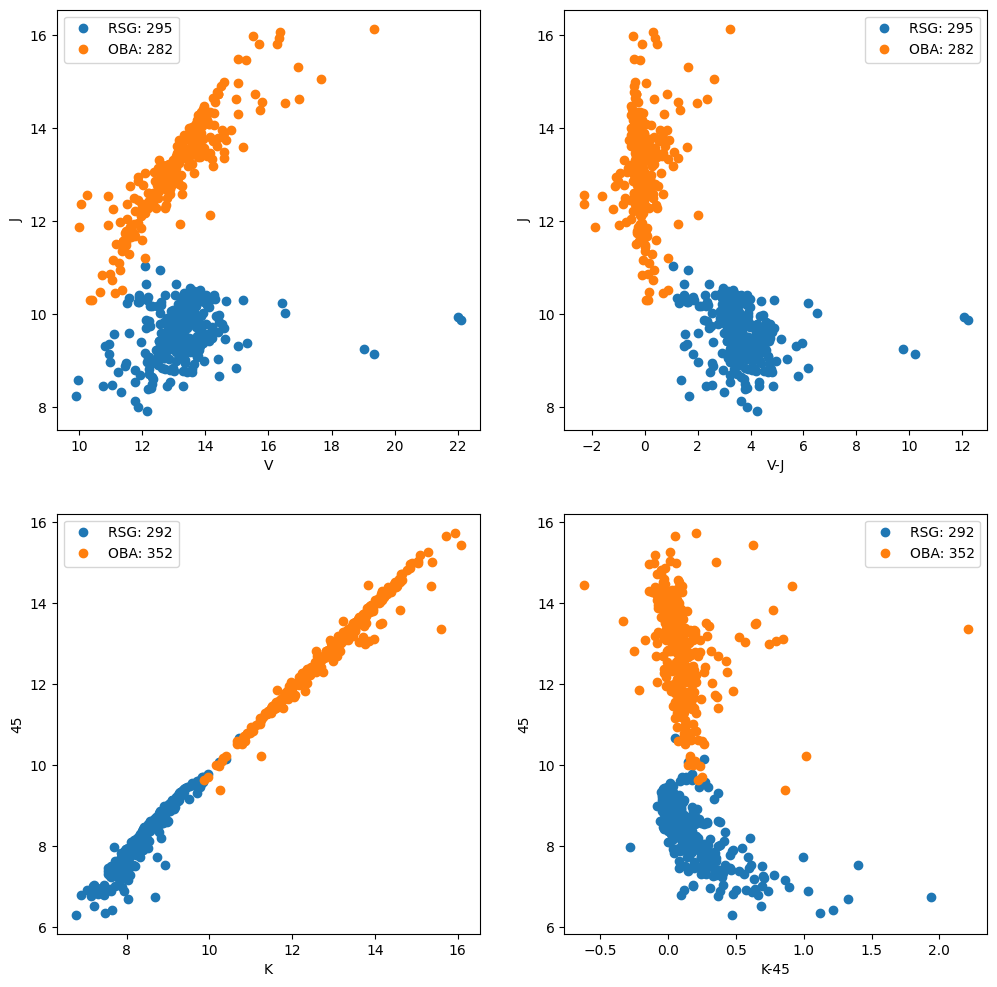

In [8]:
fig, ax = plt.subplots(2,2, figsize=(12, 12))

#selected_spt = unique_cls              # if you want to print all
selected_spt = ['RSG', 'OBA']     # put your selection here

# plot 1
band1_1 = 'V'
band1_2 = 'J'

# plot 2
band2_1 = 'K'
band2_2 = '45'

print('- plot1:')
for s in selected_spt: 
    plt1 = selmags( band1_1, band1_2, s)

    ax[0,0].plot(plt1[0], plt1[1], 'o', label=f'{s}: {len(plt1[0])}')
    ax[0,0].set_xlabel(f'{band1_1}') #'-{band1_2}')
    ax[0,0].set_ylabel(band1_2)
    ax[0,0].invert_yaxis()
    ax[0,0].invert_xaxis()
    ax[0,0].legend()

    ax[0,1].plot(plt1[0]-plt1[1], plt1[1], 'o', label=f'{s}: {len(plt1[0])}')
    ax[0,1].set_xlabel(f'{band1_1}-{band1_2}')
    ax[0,1].set_ylabel(band1_2)
    ax[0,1].invert_yaxis()
    ax[0,1].legend()
    
    
print()
print('- plot2:')        
for s in selected_spt:
    plt2 = selmags( band2_1, band2_2, s)
    ax[1,0].plot(plt2[0], plt2[1], 'o', label=f'{s}: {len(plt2[0])}')
    ax[1,0].set_xlabel(f'{band2_1}') #'-{band2_2}')
    ax[1,0].set_ylabel(band2_2)
    ax[1,0].invert_yaxis()
    ax[1,0].invert_xaxis()    
    ax[1,0].legend()
    
    ax[1,1].plot(plt2[0]-plt2[1], plt2[1], 'o', label=f'{s}: {len(plt2[0])}')
    ax[1,1].set_xlabel(f'{band2_1}-{band2_2}')
    ax[1,1].set_ylabel(band2_2)
    ax[1,1].invert_yaxis()
    ax[1,1].legend()
    

plt.show()

## Play time: Experiment with various combinations and try to answer

**1. What happens if you start increasing the number of classes to consider ?**
<br>
<details>
<summary>Click for answer</summary>
The task becomes more difficult as classes start to overlap. Some combinations may prove better to separate some classes but there is not a single optimal one.      
</details>
    
**2. How the selection of bands (e.g. adding) influence the objects to keep ?**
<br>
<details>
<summary>Click for answer</summary>
In order to plot a CMD we need sources with measuremets in both bands. By enforcing this we actually exclude objects with missing data. That results in decreasing number of sources.
</details>

**3. Would you prefer to use  combinations with few or more objects ?**
<br>
<details>
<summary>Click for answer</summary>
In principle we want to use all available information from all sources, so that the algorithm will "learn" better the properties of each class. Hence we would like to maximize the number of sources used. In problems with already small numbers (like in this example) this becomes even more critical (because we do not want to leave out objetcs, i.e. information).
</details>

<font size=4><center>**What have we achieved so far?**</center></font>
<center>To <i>examine our data</i> and <i>select which features</i> to use. <br>The time has come to <i>select an algorithm</i>! </center>

# The Support Vector Machine (SVM) algorithm

## The boundary

Support vector machine (SVM) is a way of choosing a decision boundary between different classes.

The classification boundary is provided by the hyperplane maximizing the distance between the hyperplane itself and the closest point from either class. This distance is called **margin**. Points on the margins are called **support vectors**.


<center>
<table><tr>
    <td width=400>
        <img src="images/SVM_1.png">
    </td>
    <td width=400>
        <img src="images/SVM_2.png">
    </td>
</tr></table>
    Figure 3.1. Left: Hyperplane (dashed line) separating two classes (_red_ and _green_). Right: The closest points to the hyperplane from each class constitute the "tip" of the support vectors.
</center>

The left panel of Figure 3.1 a shows two different classes distributing in a scatter plot according to variable $x_1$ and $x_2$. The right panel of Figure 3.1 explains the origin of the name support vectors: the closest points _support_ the hyperplanes (solid lines) equally distant from the decision hyperplane (dashed line).

Infinite possible boundaries can separate the two classes. SVM algorithms find the one that maximizes the distance between the supported hyperplanes.

## Minimizing the loss function - again !

The supported hyperplanes (solid-lines in Figure 3.1) can be defined as:

 $$ w \cdot x + b = +1 $$

 $$ w \cdot x + b = -1 $$

where x is the coordinate on the (x1, x2) plane, w is a 2$\times$1 matrix and b a scalar. It turns out that these hyperplanes are separated by a distance 2 / ||w||. Finding the _ideal classification boundary_, i.e. the one maximizing the distance, is therefore a problem of **minimizing ||w||**

$$ min(Loss) = min(||w||) $$.

This is what SVM algorithms do.

&#9733; For a complete mathematical formulation, consult the [Idiot’s guide to Support vector
machines, by Robert Berwick]( http://web.mit.edu/6.034/wwwbob/svm-notes-long-08.pdf).

## Separatable classes (or not)

We cannot always assume that 2 classes are separable without "contamination". That is why SVM algorithms includes a tunable parameter ($C$) which penalizes misclassifications.


<div style="text-align: center;">
<img src="images/svm-parameter-c-example.png" width=800> 
Figure 3.2. The effect of <i>C</i> parameter in the misclassifications.<br>
(Credit: <a href="https://learnopencv.com/svm-using-scikit-learn-in-python/"
 target="_blank" rel="noopener noreferrer">SVM: What makes it superior to the Maximal-Margin and Support Vector Classifiers?, by Shivam Sharma</a>)
    </img>
    </div>
    
- Small $C$ &#8594; wide margin &#8594; allows more misclassification <br>
- Large $C$ &#8594; narrow margin &#8594; allows less misclassification    

However, the SVM finds the hyperplane that maximizes the margin, and indirectly minimizes the misclassifications. In other words, SVM is not designed to minimize the contamination _per se_.


## Multiple classes

The SVM method can be applied for multiple classes as well.

<center><img src="images/svm_many_classes.png" width=400> 
Figure 3.3. SVM applied to 3 different classes.<br>
</center>

## Multiple dimensions

If our sample characterized by three parameters (X, Y, Z), then the scatter plot has 3 dimensions. The boundary between the classes in the 3-D plot is a plane. Because of the fact that the method can be extrapolated at N-dimensions, the boundary is a *hyperplane*.

<img src="images/svm_3d.png" width=400>
<center>
    Figure 3.4: Support vector machine applied for 3-D features and three classes.
</center>

## Non-linear boundaries

Sometimes, linear boundaries may not be optimal and a non-linear SVM should be used instead. The left panel of Figure 3.5 shows an 2D scatter plot of two different classes (e.g. red and green stars with different radii and temperatures) which cannot be linearly separated.

In order to find non-linear boundaries we can tackle the problem in an higher dimensional space. We use a process called **kernelization**, which consists in using a kernel function to attribute to our data a value in the additional dimension. Then, we draw the decision hyperplane into this higher dimensional space.

The central panel of Figure 3.5 shows that once the 2D data are mapped to a 3D space by attributing a $z$ value through a Gaussian-like function, the classes are easily separable by a 3D hyperplane. Projecting back the plane in 2D, we obtain the non-linear boundary (Figure 3.5, rght panel).

<img src="images/kernel.png" width=800>
<center>
    Figure 3.5. When no linear boundaries can be used the SVM method can be applied by using kernel.
</center>

## Choosing the kernel function

Useful kernel functions shall satisfy specific conditions, so that in practice only a few are used. In the example of Figure 3.5, the Gaussian Radial Basis Function is used:

$$K(x,y) = e^{-\gamma(x-y)^2}$$

where $\gamma$ is a hyperparameter which shall be learned (in our example we use an arbitrary value but in principle we should use cross-validation methods).

## Final remarks on SVM

**Pros**
* Good at dealing with high dimensional data
* Works well on small data sets

**Cons**
* Picking the right kernel and parameters can be computationally intensive
* It suffers from contamination

&#9733; For further information on SVM, consult [Support Vector Machine - Classification, by Saed Sayad](http://www.saedsayad.com/support_vector_machine.htm).

# SVM in practice

## The binary problem

In this case we examine a binary classification problem where we select one class (or more that will group into a single one) and the rest classes as contaminants. The purpose is to check if we can separate efficiently these two classes.

In [9]:
def process_data( bands2use, binary_classes2use  ):
    """
    Process input data to return arrays 
    of magnitudes and (consecutive) colors
    based on the input bands (band2use).

    Option to prepare data for binary classification
    if binary_classes2use contains classes or not.
    
    Selected objects are assigned 1, while the contaminants 0.
    
    """
    pd_ml_data_mags = []   # working with magnitudes directly
    pd_ml_data_clrs = []   # taking color terms, i.e. mag1-mag2
    pd_ml_labels    = []
    pd_ml_objects   = []

    print(f'# stars with mags in: {",".join([bb for bb in bands2use])}')
    print("=========================")
    print("Type    initial    final ")
    print("-------------------------")
    init = 0 # initial total number of stars (added after each iteration)

    for sptype in unique_cls:
        indcs = classes[sptype]
        kept = []
        init += len(indcs)
        for star in indcs:
            mag_list = list(data[star][bands2use])
            # rejecting stars with missing values
            if miss_value in mag_list:
                #print('REJECTING!!! <',data[star])
                continue
            else:
                # creating the magnitude list
                mag = [ i for i in mag_list ] #data[star][bands_selected] ]

                # creating the color term (index)
                clr = [mag[i]-mag[i+1] for i in range(len(mag)-1)]

                pd_ml_data_clrs.append(clr)
                pd_ml_data_mags.append(mag)
                pd_ml_objects.append(data[star]['Name'])
                kept.append(sptype)           

                # selecting class(es) to examine for binary classifier
                if len(binary_classes2use)!=0:
                    if sptype in binary_classes2use:
        #                print(f'. keeping {sptype}')
                        label_sptype = 1
                    else: 
        #                print(f'. not considering {sptype}')
                        label_sptype = 0
                    pd_ml_labels.append(label_sptype)
                else:
                    pd_ml_labels.append(sptype)

        print(f'{sptype:<4}  {len(indcs):>9} {len(kept):>8}')
    print('-'*24)
    print(f'TOTAL:  {init:>7}  {len(pd_ml_data_mags):>7}') 
    if len(binary_classes2use)!=0:
        print('='*24)
        print(f'classifying:  {len(pd_ml_labels)-pd_ml_labels.count(0):>10}') 
        print(f'contaminants:  {pd_ml_labels.count(0):>9}') 


    pd_ml_data_mags = np.asarray(pd_ml_data_mags)
    pd_ml_data_clrs = np.asarray(pd_ml_data_clrs)
    pd_ml_objects   = np.asarray(pd_ml_objects)
    pd_ml_labels    = np.asarray(pd_ml_labels)
          
    return pd_ml_data_mags, pd_ml_data_clrs, pd_ml_objects, pd_ml_labels

In [10]:
reminder()

Available bands to use: 
U,B,V,I,J,H,K,36,45,58,80,24
-------------------------
Available classes to use:
OBA,OBAe,RSG,WR,YSG


Select here the class(es) you would like to distinguish from the rest, along with the bands to use.

In [11]:
class2keep = ['RSG']
# Select the bands you want to use here:
bands_selected = ['V', 'J', '45'] 

In [12]:
ml_data_mags, ml_data_clrs, ml_objects, ml_labels = process_data( bands_selected, class2keep)  

# stars with mags in: V,J,45
Type    initial    final 
-------------------------
OBA         370      276
OBAe         73       65
RSG         297      291
WR           91       76
YSG         208      208
------------------------
TOTAL:     1039      916
classifying:         291
contaminants:        625


_NOTE_: the process_data() function examines and keeps only the sources with values across all bands. In other words, we remove sources with missing values (according to the bands selected). 

Let's print the labels to see how they look like.

In [13]:
print(ml_labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

_NOTE_: If you have more than 2 bands selected the following plot will use the first two. Modify accordingly to plot other combinations.

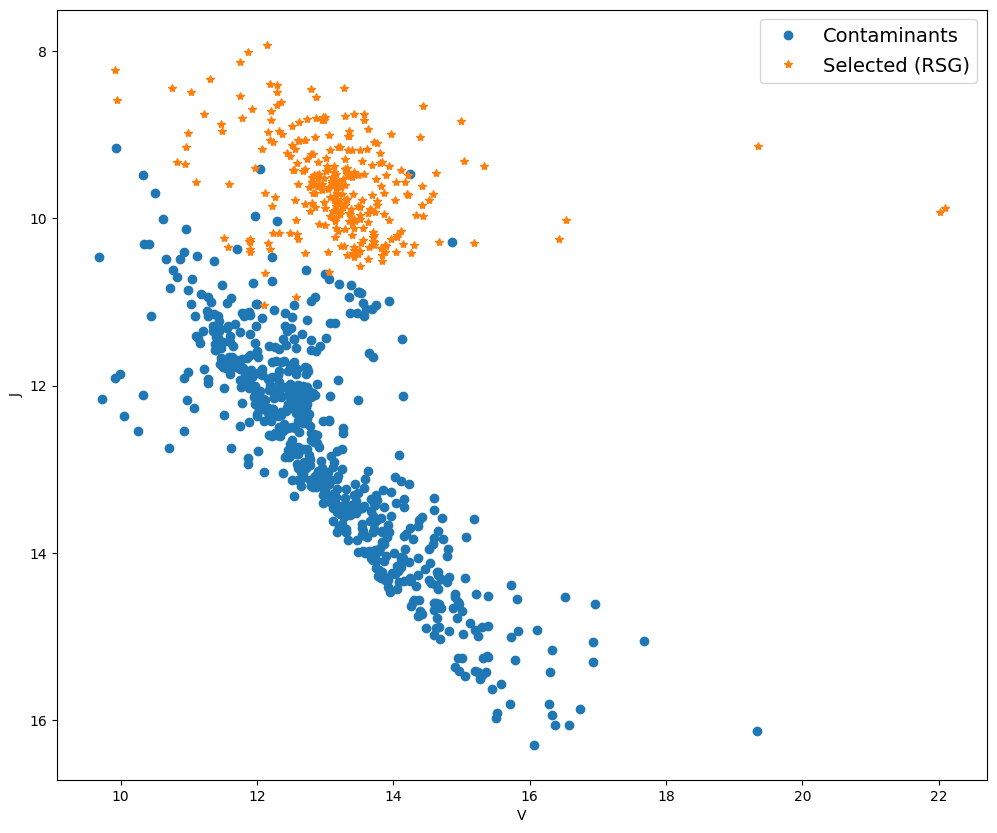

In [14]:
fig = plt.figure(figsize=(12,10))

conts = np.where( ml_labels==0 )[0]
clasf = np.where( ml_labels!=0 )[0]

plt.plot( ml_data_mags[conts][:,0], ml_data_mags[conts][:,1], 'o', 
             label='Contaminants')
plt.plot( ml_data_mags[clasf][:,0], ml_data_mags[clasf][:,1], '*', 
             label=f'Selected ({"+".join(class2keep)})')
plt.gca().invert_yaxis()

plt.xlabel(f'{bands_selected[0]}') #'-{bands_selected[1]}')
plt.ylabel(bands_selected[1])
plt.legend(fontsize=14)
plt.show()


## Introducing data splitting and the Golden rule

In supervised approaches we want to "teach" the algorithms what they need to learn, before start the predictions. In this case we want the SVM to identify the common properties of the two sub groups (1 including all possible classes used, and 0 as contaminants). However, if we provide all data the algorithm will learn this "by heart" and fit them perfectly (called **overfitting**), and when new data appear will probably misclassify. 

So, what can we do ? We have to **split the data** and follow the **Golden rule**.

<table><tr>
    <td width=640>
        <img src="images/Train_Validation_Test.png">
        <center>
            <br>
            Figure 4.1.  Indicative recipe for splitting a dataset into the analysis sets.<br>
            For very large datasets (above 10$^5$ entries), the percentages of validation and test can be substantially smaller.
            <br>
        </center>
    </td>
</tr></table>

What are the different sets for? 

- **Train** set $~~~~~~\rightarrow$ **Learn** the model parameters

- **Validation** set $\rightarrow$ Check that the learnt model is not **overfitting/underfitting** the train set

- **Test** set $~~~~~~~\rightarrow$ **Assess** the model performance


<font size=4><center>**Golden Rule of Machine Learning**</center></font>
<center>Treat the <i>test</i> data as if they come from the <i>future</i>!</center>

So let's go on and split our data now. 

_NOTE_: We will only use the train/test split as our purpose now is not to optimize the model (you will see more on that in **ML_Practices**).

_NOTE_: You can either use magnitudes (ml\_data\_mags) or color indeces (ml\_data\_clrs).


In [15]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(ml_data_mags, ml_labels, 
                        test_size=0.3) #, random_state=42) 

print(f'- From {len(ml_objects)} sources:')
print(f'   {len(X_train)} (training)')
print(f'   {len(X_test)} (test)') 
print()
print(f'Test labels: {y_test}')


- From 916 sources:
   641 (training)
   275 (test)

Test labels: [0 1 1 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 1 1
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 1 1 1 0 0 0
 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 0 0 0 0 0 1 0 0 1 1 0 0 1 0 1 0 0 0 0 1 0 1 0 0 1 1 1 0 0 0 0 0 0 0
 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0
 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 0 1 1 0 0 0 0 1 0 1 0 0 1
 0 1 0 1 0 0 0 1 1 0 0 1 1 0 0 1]


## Questions: 

**1. What happens when you repeat the process?**

_HINT_: Use Ctrl+Enter to run a cell without continuing to the next one
<br>
<details>
<summary>Click for answer</summary>
The process is random so every time different objects are selected as train to test. 
</details>

**2. How can we solve this?**

_HINT_: Check the online documentation ([train-test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html))
<br>
<details>
<summary>Click for answer</summary>
We can use <code>random_state</code> to have the same split all the time (this is mainly for developing and debugging pusposes, as it helps to reproduce the results).
</details>

**3. Where does 42 comes from?**
<br>
<details>
<summary>Click for answer</summary>
Whaat? You do not know?<br>
<ul>
    <li> shame on you!
    <li> read <i>The Hitchhiker's Guide to the Galaxy</i> by Douglas Adams!!!
    </ul>
    </details>

Now, let's use the classifier to fit our training set (X_train) and predict the classes of the test samples (X_test). We will print some metrics to check the performance.

In [16]:
from sklearn import metrics

clf = SVC(kernel='linear') 
clf.fit(X_train, y_train)
yhat = clf.predict(X_test)
#print(yhat)

print(f"Classification report:\n\n {metrics.classification_report(y_test, yhat)}") 
print(f"Confusion matrix: \n\n {metrics.confusion_matrix(y_test, yhat)}")

Classification report:

               precision    recall  f1-score   support

           0       0.98      0.98      0.98       197
           1       0.95      0.96      0.96        78

    accuracy                           0.97       275
   macro avg       0.97      0.97      0.97       275
weighted avg       0.97      0.97      0.97       275

Confusion matrix: 

 [[193   4]
 [  3  75]]


**but**... _aaarg, what are all these metrics about ?_

## Model evaluation metrics - a mini discussion!

There is a number of assessment metrics for the performance of a classifier. We start by introducing the idea of the **confusion matrix**. 

<center><img src="images/confusion_matrix-mod.png" width=400> 
Figure 4.2. Confusion matrix for classification.<br>
(Credit: <a href="https://towardsdatascience.com/precision-vs-recall-386cf9f89488"  target="_blank" rel="noopener noreferrer">Precision vs Recall by Shruti Saxena</a>)</center>


Defining some metrics:

$$ \rm{Precision} =  \frac{\rm{True~Positives}}{\rm{Actual~Results}} = \frac{\rm{True~ Positives}}{\rm{True~Positives\,+\,False~Positives}} $$ 

$$ \rm{Recall} = \frac{\rm{True~Positives}}{\rm{Predicted~Results}} = \frac{\rm{True~ Positives}}{\rm{True~Positives + False~Negatives}} $$ 

$$ \rm{F1-score} = 2 \times \frac{\rm{Precision}\times\rm{Recall}}{\rm{Precision}+\rm{Recall}}$$

$$ \rm{Accuracy} = \frac{\rm{True~Positives}\,+\,\rm{True~Negatives}}{\rm{Total}} $$ 

<br>
<div style="text-align: center;">
Support: number of test objects per class<br><br>
Macro avg: averaging the unweighted mean per label<br><br>
Weighted avg: averaging the support-weighted mean per label
</div>

---

_Note 1_: You may also encounter the terms _sensitivity_ and _specificity_ which corresponds to the recall of the positive and the negative class, respectively, in binary problems. 

_Note 2_: In astrophysics we use the terms _completeness_ and _contamination_ (see [Classification, by Andy Connolly](http://connolly.github.io/introAstroML/blog/classification.html)):

$$ \rm{completeness} = \frac{\rm{True~Positives}}{\rm{All~real~Positives}} = \frac{True~Positives}{True~Positives + False~Negatives} = recall$$

$$ \rm{contamination} = \frac{False~Positives}{All~detected~Positives} = \frac{False~Positives}{True~Positives + False~Positives}$$

---

**Question:** What **metric of performance** shall we maximize, to optimize our model parameters?<br>
It depends on the **objective of the model**.

Example 1: We want to identify best follow-up candidates of GW sources, without wasting precious time on wrong targets

    TP: identified as GW, and it is GW
    FP: identified as GW, but not GW
    TN: not identified as GW, and not GW
    FN: not identified as GW, but is GW
 
<details>
<summary>Which metric is more important? (click!) </summary>
Observing GW candidates means that no time should be spent on FP, so we need to minimize this and <b>maximize Precision</b>.
</details>

Example 2: We want to create a catalog of OB stars, so we would like to retrieve the whole population

    TP: identified as OB, and it is OB
    FP: identified as OB, but not OB
    TN: not identified as OB, and not ON
    FN: not identified as OB, but is OB
    
<details>
<summary>Which metric is more important? (click!) </summary>
We would like to be complete on the catalog, so we should not miss any of the OB population (even at the expense of some FP). Therefore, we need to minimize FN, and <b>maximize Recall</b>.

</details>

An interesting presentation of this topic can be found [here](https://towardsdatascience.com/precision-and-recall-a-comprehensive-guide-with-practical-examples-71d614e3fc43). 

- - -

But there is an important detail: we need to decide the **threshold**: i.e.,  the _probability score_ at which an object is classified as class 0 or 1.

<br>
<center><i>By default, we and <code>sklearn</code> classifiers assume <b>50%</b> as the score threshold</i></center>

... but this can change! For example, considering the previous scenarios:

 1. to identify best follow-up candidates of GW sources, we want to waste no precious time on wrong targets --> we can **increase** the threshold to be stricter in our selection (we lower FP) and we **increase Precision**. But now we reject more (**FN increases**) and **Recall decreases**. 

 2. to create a catalog of OB stars, we want to be as complete as possible, so in order to recover the OB population we **decrease FN** (**increased Recall**) but at the expense of **more FP**, and therefore **decreased Precision**.
 
 Therefore, the  **metrics** change based on the chosen threshold.
<br><br>

**Question:** Can we visualize my classifier's expected behaviour when changing the threshold?<br>
Yes, plot the **Receiver Operating Characteristic (ROC)** curve.

The ROC shows the classifier's TPR and FPR across all possible classification thresholds.


<table><tr>
    <td width=640>
        <img src="images/ROC.png">
        <center>
            <br>
            Figure 4.3.  Example of a Receiver Operating Characteristic (ROC) with an AUC of 0.79.
            <br>
            (From <a href="https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py"><code>sklearn</code> ROC page</a>)
        </center>
    </td>
</tr></table>

- - -

**Question:** In the case of <u>multiple models</u> (each one with its ROC curve) which one is the _best_ model **over all thresholds**?!<br>
We can claim it is the one that strikes the <u>best balance</u> between TPRs and FPRs across all possible classification thresholds.

<table><tr>
    <td width=640>
        <img src="images/ROCs.jpg">
        <center>
            <br>
            Figure 4.4.  ROC curves for different classifiers.
            <br>
            (From <a href="https://cuitandokter.com/"><code>sklearn</code> ROC page</a>)
        </center>
    </td>
</tr></table>

It is also possible to do the same with Precision-Recall plots (more accurate especially with imbalanced data). 

<table><tr>
    <td width=640>
        <img src="images/precision-recall_plot.png">
        <center>
            <br>
            Figure 4.5. Precision-Recall plot for different classes .
            <br>
            (Adapted from Fig. 4 by <a href="https://ui.adsabs.harvard.edu/abs/2022A%26A...666A.122M/abstract">Maravelias et al. (2022)</a>)
        </center>
    </td>
</tr></table>


**Question:** Is there a way to do that without looking at the plots? </br>
Sure, the **Area Under the ROC Curve (AUC)** measures exactly this.

_NOTES_: 

- The 1-to-1 line in Figure 2 indicates a **random** classifier (in binary case, it means it randomly assigns class 1 or 0).<br>
  For this reason, the minimal AUC is _de facto_ 0.5.
- The **furthest** from the 1-to-1 line, the **better** the classifier.
- The **ideal** classifier has AUC = 1.

For more info about the interpretation of the AUC, you can read [this page](https://towardsdatascience.com/interpreting-roc-curve-and-roc-auc-for-classification-evaluation-28ec3983f077) and [this post on Google Developers](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc).

<br>

**Question**: Is AUC a metric **superseeding** all the others?

- In general: <u>no</u>, they measure different things
    
  _AUC gives performance across all thresholds, but in practice you pick **one** threshold when you use the model_  
  
  
- If your classes are heavily unbalanced: <u>probably</u>

  _In this case it is possible that you don't know the right threshold anyways_
    
You can find an interesting discussion about this topic [here](https://datascience.stackexchange.com/questions/806/advantages-of-auc-vs-standard-accuracy).

---

And now let's go on with our example... plotting a prettier presentation of the previous confusion matrix. 

In [18]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
                  
                  
    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, alpha=0.5)
#    plt.title(title)
    cbar = plt.colorbar()
    cbar.set_label('# sources', fontsize=16)
    cbar.ax.tick_params(labelsize=16) # (fontsize=15)
   

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45, fontsize=15)
        plt.yticks(tick_marks, target_names, fontsize=15)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.3f}".format(cm[i, j]),
                     horizontalalignment="center", color="black", fontsize=14 )
                     #color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center", color="black") 
#                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label (accuracy={:0.2f})'.format(accuracy, misclass), fontsize=16)
    plt.show()


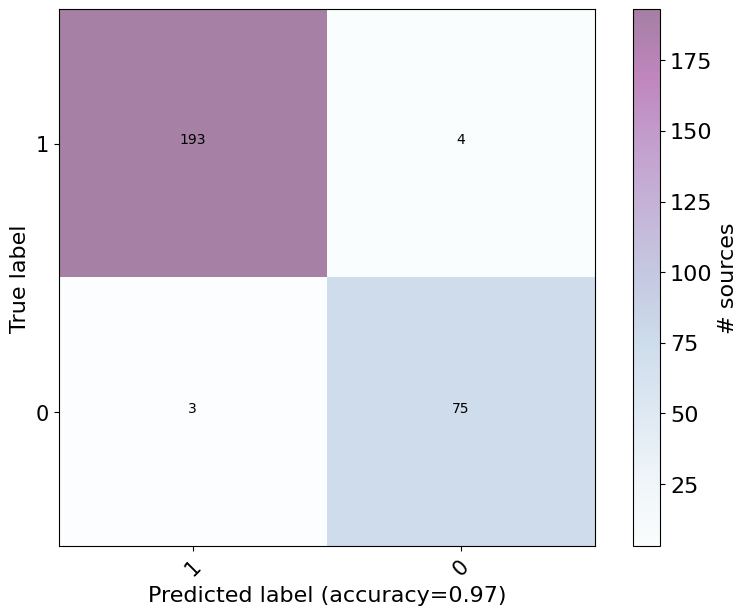

In [21]:
plot_confusion_matrix( metrics.confusion_matrix( y_test, yhat),
                      [1, 0],
                      title='Confusion matrix', cmap='BuPu', # for more options see: https://matplotlib.org/stable/tutorials/colors/colormaps.html
                      normalize=False  # True returns fraction, False raw numbers
                      ) # YlOrBr



## Play time: Experiment with some selections

**1. What happens if we start adding more classes into the selected one ?**
<br>
<details>
<summary>Click for answer</summary>
The accuracy drops as more classes results in a more complex problem and the classes may overlap in the feature space (confusing the classifier even more!).
</details>

**2. What happens when we start changing the $C$ parameter?**

_HINT_: the default value is 1, so start increasing it.

<br>
<details>
<summary>Click for answer</summary>
A lower value off C allows for more misclassifications, i.e. more sources are found away from the diagonal in the confusion matrix. As we increase its value the decrease but we will lose in prediction power.  
</details>

## The multi-class problem

Now we approach the same problem as a multi-class one, i.e. we are using the SVM as a classifier that can handle all classes simultaneously. 

In [22]:
reminder()

Available bands to use: 
U,B,V,I,J,H,K,36,45,58,80,24
-------------------------
Available classes to use:
OBA,OBAe,RSG,WR,YSG


In [23]:
bands_selected = ['V', 'J', '45'] 

_NOTE: in this case the list for the classes should be empty ([]) to include all classes._

In [24]:
ml_data_mags, ml_data_clrs, ml_objects, ml_labels = process_data( bands_selected,[])  

# stars with mags in: V,J,45
Type    initial    final 
-------------------------
OBA         370      276
OBAe         73       65
RSG         297      291
WR           91       76
YSG         208      208
------------------------
TOTAL:     1039      916


Now if we print the labels again, we notice that the array is totally different and the multiclass output is evident.

In [25]:
print(ml_labels)

['OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA'
 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA'
 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA'
 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA'
 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA'
 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA'
 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA'
 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA'
 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA'
 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA'
 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA'
 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA'
 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA'
 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'OBA' 'O

## Splitting into train and test sets for multi-class

We are using again the train-test split approach but considering all classes now.

In [26]:
indices = np.arange(len(ml_labels))
X_train, X_test, y_train, y_test = train_test_split(ml_data_mags, ml_labels,
                                shuffle=True, stratify=ml_labels, 
                                test_size=0.1) #, random_state=42) 

print(f'> From {len(ml_objects)} sources we use {len(X_train)} for training and {len(X_test)} for testing.') 

print('\nStatistics per class:')
k = 0
for c in unique_cls:
    items_train = np.where( y_train==c )[0]
    items_test  = np.where( y_test==c )[0]
    items_total = np.where( ml_labels==c )[0]
    print(f'> For {c} there are {len(items_total)} sources split in {len(items_train)} (train) and {len(items_test)} (test) samples')



> From 916 sources we use 824 for training and 92 for testing.

Statistics per class:
> For OBA there are 276 sources split in 248 (train) and 28 (test) samples
> For OBAe there are 65 sources split in 59 (train) and 6 (test) samples
> For RSG there are 291 sources split in 262 (train) and 29 (test) samples
> For WR there are 76 sources split in 68 (train) and 8 (test) samples
> For YSG there are 208 sources split in 187 (train) and 21 (test) samples


## Play time: Check the train-test splitting

**1. Run train-test split a few times as it is  - do you notice anything strange?** 

_HINT_: try to reduce the test_size, for the evidence to become clearer. 
<br>
<details>
<summary>Click for answer</summary>
It is possible to get 0 test objects for some classes. This is due to the randomness of the selection and the low number of sources in some of the classes. 
</details>

**2. How can we correct for the effect in the previous question?**

_HINT_: Check the documentation ([train-test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)) and find out which parameters help.
<br>
<details>
<summary>Click for answer</summary>
Add shuffle=True and stratify ensures that the test sample will keep the demographics of the original one. 
</details>


<font size=4><center>Important take-away message #1</center></font>
<center>sklearn <i>documentation</i> is your friend !</center>

Let's produce some results now...

Classification report:

               precision    recall  f1-score   support

         OBA       0.82      0.82      0.82        28
        OBAe       0.50      0.33      0.40         6
         RSG       0.94      1.00      0.97        29
          WR       0.86      0.75      0.80         8
         YSG       0.77      0.81      0.79        21

    accuracy                           0.84        92
   macro avg       0.78      0.74      0.76        92
weighted avg       0.83      0.84      0.83        92

Confusion matrix: 

 [[23  0  0  0  5]
 [ 3  2  0  1  0]
 [ 0  0 29  0  0]
 [ 0  2  0  6  0]
 [ 2  0  2  0 17]]


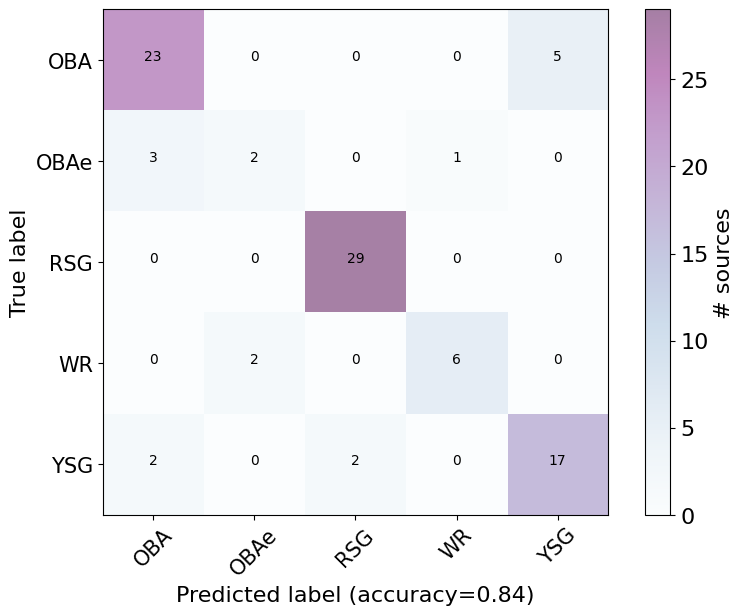

In [27]:
clf2 = SVC(kernel='linear') 
clf2.fit(X_train, y_train)
yhat = clf2.predict(X_test)
#print(yhat)

#confmatrix = metrics.confusion_matrix( y_test, yhat)
print(f"Classification report:\n\n {metrics.classification_report(y_test, yhat)}") 
print(f"Confusion matrix: \n\n {metrics.confusion_matrix(y_test, yhat)}")

plot_confusion_matrix( metrics.confusion_matrix( y_test, yhat),
                      unique_cls,
                      title='Confusion matrix', cmap='BuPu', # for more options see: https://matplotlib.org/stable/tutorials/colors/colormaps.html
                      normalize=False  # True returns precent, False raw numbers
                      ) # YlOrBr

## Questions: 

**1. How does the result changes with respect to the binary case?** 
<br>
<details>
<summary>Click for answer</summary>
We see a drop in the accuracy, because we try to classify more classes which are actually not easilly separated in the feature space. In other words, some classes may have similar magnitudes and colors, which makes it difficult to separate them. 
</details>

**2. How does the result change with kernel ?** 

_HINT_: check sklearn.svm.SVC
<br>
<details>
<summary>Click for answer</summary>
Adding more classes (and bands) increases the dimensionality of the problem, therefore, there is a more complex representation of the input data. Kernels help to fit them more efficiently since they are able to "see" in more dimensions.   
</details>


<font size=4><center>Important take-away message #2</center></font>
<center>Accuracy is <i>not</i> the best metric to use when we have imbalanced datasets.</center> 

# The Random Forests algorithm

## Decision Tree

A **Decision Tree** (**DT**) is simply a top-to-bottom tree-like structure where each node corresponds to a question (or a set of features more generally) that distinguishes objects to two groups, left and right from the node. A decision tree presents the drawback of learning extremely well the training set. That means that DTs overfit the data and they cannot predict very accurately new data.

<center><img src="images/DecisionTree.jpg/" width=400> 
Figure 5.1. Quick introduction to Decision Trees - how to fulfill an everyday need.<br>
(Credit: G. Maravelias)</center>

### Minimizing what?

To find the optimal way to partition objects, the algorithm needs a metric to quantify this process. One such metric is the Gini impurity, which calculates the probability of an object being incorrectly classified (or assigned to the wrong class) when chosen randomly. It is defined by the formula
 
$$ Gini = 1 - \sum\limits_{i=1}^{n} (p_i)^2 $$

where $n$ is the number of classes, and $p_i$ is the probability of an object belonging to a specific class for a given value of the variable (feature) under consideration. These probabilities are summed across all values of the feature and all corresponding classes.

The Gini impurity for a node is determined by the average of these values across all classes, weighted by their frequency ([for a detailed presentation](https://blog.quantinsti.com/gini-index/)).

If all objects in a set belong to the same class, the Gini impurity is 0. If it is 1, the class assignments of the objects are random.

##  Random Forests

**Random Forests** (**RF**) or Random Decision Trees ([Breiman (2001), Machine Learning, 45, 5](https://doi.org/10.1023/A:1010933404324)) is a generalization of the DTs, as it utilises a multitude of decision trees. When RF are used as a classification method, for each input datum the final output is the class (/value) given by the mode of the classes of the individual trees.


<center><img src="images/RandomForests.jpg" width=800> 
Figure 5.2. Schematic description of the Random Forest classifier.<br>
(Credit: G. Maravelias)</center>


RF creates a large number of DTs through random selection of a subset of the training set as well as a random selection of features. This randomness reduces the correlation between the different DTs. Since the DTs have different conditions in their nodes and different overall structures, this diversity yield overall robust predictions. 

Once the RF has been trained, the data of an **unlabeled** source (to be classified) are  fed into all DTs of the forest. According to its properties and the nodes in each DT, it follows a specific path which leads to a given class. The final output of the RF (the prediction) is an aggregation of all DTs by means of a majority vote.

The fact that RF combines the prediction for a number of individual trees makes it an **ensemble** method.

&#9733; [Reis, Baron, & Shahaf (2019), AJ, 157, 16](https://ui.adsabs.harvard.edu/abs/2019ascl.soft03009R/abstract) provide an excellent description of RFs (for a two-class problem) and present a  probabilistic RF method which takes into account the uncertainties on the data and their labels.

## Final remarks on Random Forests

In machine learning most of the effort is actually spent on the **sample** selection and, most importantly, on the selection of the **features** used for the classification (feature engineering).

RF partially overcome the latter problem by training each DT on a different sub-set of features, hence training the algorithm to recognize the features which mostly differentiate the objects.

**PROS**
- No need of scaling or transformation of the initial data.
- Implicit feature selection.
- Suitable for large datasets with many features.


**CONS**
- Not easily interpretable.
- Hyperparameter needs good tuning for high accuracy.  

# Random Forests in practice

For the implementation, we will use the [`sklearn.RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), whose basic parameter (among others) is `n_estimators`, i.e. the number of trees (default 100).

Using the same dataset we are now approaching the same problem using the Random Forest (both as a binary and a multiclass classifier).

---

**TASK 1: Complete the train-test split and select magnitudes to work with.**

**TASK 2: Find the proper function for RF and make predictions**

In [28]:
reminder()

Available bands to use: 
U,B,V,I,J,H,K,36,45,58,80,24
-------------------------
Available classes to use:
OBA,OBAe,RSG,WR,YSG


Add any class if you want to use RF as binary classifier, or keep the list `class2keep_RF` empty for all classes.

In [53]:
class2keep_RF=[]  
bands_selected_RF = ['U','V', 'I', 'J', 'K','36']  

In [54]:
ml_data_mags, ml_data_clrs, ml_objects, ml_labels = process_data( bands_selected_RF, class2keep_RF)  

# stars with mags in: U,V,I,J,K,36
Type    initial    final 
-------------------------
OBA         370      252
OBAe         73       60
RSG         297      249
WR           91       70
YSG         208      172
------------------------
TOTAL:     1039      803


In [55]:
# splitting data on magnitudes or colors

#X_train, X_test, y_train, y_test = train_test_split(ml_data_mags, 
X_train, X_test, y_train, y_test = train_test_split(ml_data_clrs, 
                                                    ml_labels,
                                shuffle=True, stratify=ml_labels, 
                                test_size=0.3) #,  random_state=42) 

print(f'> From {len(ml_objects)} sources we use {len(X_train)} for training and {len(X_test)} for testing.') 

# check if in binary or multi-label mode
if 1 in ml_labels: # binary
    confmat_classes = [1,0]
else:
    confmat_classes = unique_cls

    print('\nStatistics per class:')
    k = 0
    for c in unique_cls:
        items_train = np.where( y_train==c )[0]
        items_test  = np.where( y_test==c )[0]
        items_total = np.where( ml_labels==c )[0]
        print(f'> For {c} there are {len(items_total)} sources split in {len(items_train)} (train) and {len(items_test)} (test) samples')


> From 803 sources we use 562 for training and 241 for testing.

Statistics per class:
> For OBA there are 252 sources split in 176 (train) and 76 (test) samples
> For OBAe there are 60 sources split in 42 (train) and 18 (test) samples
> For RSG there are 249 sources split in 174 (train) and 75 (test) samples
> For WR there are 70 sources split in 49 (train) and 21 (test) samples
> For YSG there are 172 sources split in 121 (train) and 51 (test) samples


/tmp/ipykernel_271486/1123046546.py:12: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 1 in ml_labels: # binary


Classification report:

               precision    recall  f1-score   support

         OBA       0.79      0.83      0.81        76
        OBAe       0.67      0.44      0.53        18
         RSG       0.89      0.91      0.90        75
          WR       0.72      0.62      0.67        21
         YSG       0.71      0.76      0.74        51

    accuracy                           0.79       241
   macro avg       0.76      0.71      0.73       241
weighted avg       0.79      0.79      0.79       241

Confusion matrix: 

 [[63  1  0  3  9]
 [ 8  8  0  2  0]
 [ 0  0 68  0  7]
 [ 3  3  2 13  0]
 [ 6  0  6  0 39]]


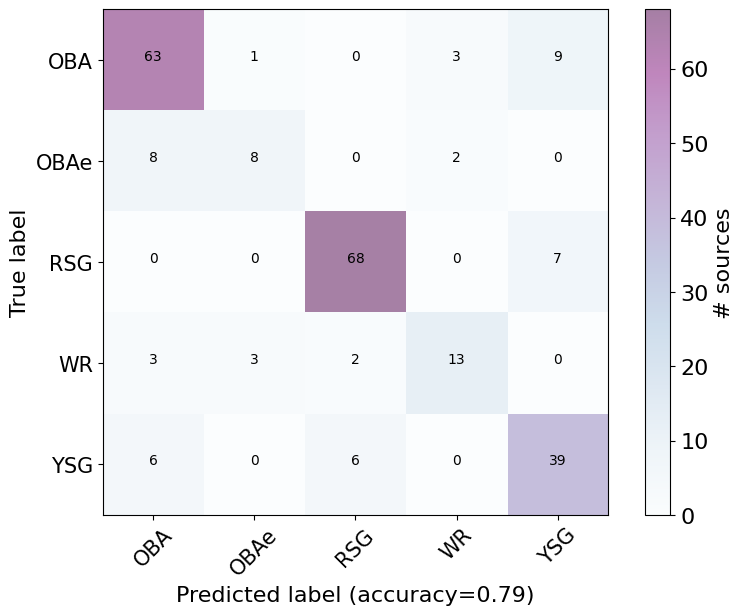

In [56]:
from sklearn.ensemble import RandomForestClassifier

clfrf = RandomForestClassifier()
clfrf.fit(X_train, y_train)
yhat = clfrf.predict(X_test)

print(f"Classification report:\n\n {metrics.classification_report(y_test, yhat)}") 
print(f"Confusion matrix: \n\n {metrics.confusion_matrix(y_test, yhat)}")

plot_confusion_matrix( metrics.confusion_matrix( y_test, yhat),
                      confmat_classes,
                      title='Confusion matrix', cmap='BuPu', # for more options see: https://matplotlib.org/stable/tutorials/colors/colormaps.html
                      normalize=False  # True returns percent, False raw numbers
                      ) # YlOrBr

## Questions: 

**1. Why the results change by re-running it ?**
<br>
<details>
<summary>Click for answer</summary>
RF as the name suggest create always a different set of trees with random eselection of features and data. Consequently, the RF from one run to the other is not the same and there are small variations. However, the results are robust because they are averaging the results from all trees. 
</details>

**2. What is the difference on the accuracy of the algorithm if we use the colors instead of the magnitudes? Why do it?**
<br>
<details>
<summary>Click for answer</summary>
Depending on the classes and bands selected the accuracy will (slightly) change. RF are rather insensitive to the input data (scaled or not). 
    
However, colors are distance-independent features, which means that a model build with these features could be applicable to other galaxies also. Colors are distance-independent features, which means that the model could be applicable to other galaxies also. On the contrary, if we use only magnitudes this would mess up the prediction as with distance the sources become fainter.  
</details>


# Classification algorithms overview

This is a presentation of the set of [**sklearn**](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html) algorithms with toy datasets, and then describe some of them. 

This serves as a showcase of the available methods and how they compare. You can easily adapt any of these methods to the following examples or your own problems. 

<div style="text-align: center;">
<img src="images/sklearn_classification.png" width=1200> 
Figure 2.1. Overview of the clustering algorithms in sklearn
</img>
    </div>

## Quizz time: take a few moments and explore the results - what do you notice? 

Write some points here:

- point 1
- point 2




## Some important take-away points

<br>
<details>
    <summary> An indicative list: </summary>
<ul>
    <li> There is not a single best algorithm. 
    <li> Some algorithms are more able to separate classes.
    <li> Some algorithms have limited ability (e.g. the linear SVM with non-linear distributed data). 
</ul>
</details>

# Recap: Initial steps to follow when building a classification model

> <font size=4>1. Examine / visualize / preprocessing data </font>
> 
> <font size=4>2. Select features</font>
>    
> <font size=4>3. Select algorithm</font>
>    
> <font size=4>4. Split data and follow Golden rule </font>
>    
> <font size=4>5. Select metrics</font>
>    
> <font size=4>6. Examine results and re-iterate </font>
    

# Further notes / resources

For the description and the application of k-Nearest Neighbors on the same example look into the [Summer School for Astrostatistics 2022 material](https://github.com/astrostatistics-in-crete/2022_summer_school).

In [ ]:
# EOF